In [1]:
import numpy as np
np.random.seed(0)
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import inf

from nnreg.analysis_fun import *
from matplotlib.patches import Rectangle
from nnreg.config import Config
from PROJECT_SETUP import ROJECT_ROOT_DIR
from RegLib.load_save_data import load_data_as_dict, load_best_checkpoint, get_previous_checkpoints
from RegLib.HelperFunctions import plot_values_with_two_y_axis, plot_values_with_info, save_figure, parse_info_for_plot

In [2]:
path_for_sdg = Path('Results', 'SDG')

def get_all_results_for_p(path:Path):
    polynomials = [2, 5, 10, 15]
    all_dir = [x for x in path.iterdir() if x.is_dir()]
    results_per_p = []
    results = {}
    for pol in polynomials:
        results[pol] = []

    for i in range(len(all_dir)):
        d = all_dir[i]
        cfg = Config(config_file = Path(d).joinpath("sgd.yaml"))
        best = load_best_checkpoint(d)

        results[cfg.DATA.FRANKIE.P].append({"LR": cfg.OPTIM.LR, "batch_size": cfg.OPTIM.BATCH_SIZE, "Eval": best["Test_eval"],"Time": best["Proccess_time"], "Step": best["Step"], "Name": d})

    return results

def analyse_results(results, round_up_to: float = 1, save_fig = False):
    min_val = get_min_value(results, "Eval")
    print("Best val: ", min_val)
    best_checkpoint = load_best_checkpoint(min_val["Name"])
   
    cfg = Config(config_file = Path(min_val["Name"], "sgd.yaml"))
    p = str(cfg.DATA.FRANKIE.P)

    time_for_best_run = f'{min_val["Time"][0]:.0f} min {min_val["Time"][1]:.0f}'
    best_test_eval = f'{min_val["Eval"]:.5f}'
    
    # HEAT_MAP
    info_to_add = {}
    s_results = unpack(results, replace_val_bigger = inf)
    position_index = s_results.index.get_loc(min_val["batch_size"])
    position_column = s_results.columns.get_loc(min_val["LR"])

    show_heatmap(s_results, info_to_add = info_to_add, patch_placement= (position_column, position_index), title = f"SGD on Franke p={p}", xlabel = 'Learning rate', ylabel = 'Batch size', show_bar = False, save_fig = save_fig)

    print(f'{min_val["Eval"]} replacing with: {round_up_to}')
    s_results = unpack(results, replace_val_bigger = round_up_to)
    show_heatmap(s_results, info_to_add = info_to_add, patch_placement= (position_column, position_index), title = f"SGD on Franke p={p} (Filtered)", xlabel = 'Learning rate', ylabel = 'Batch size', show_bar = True, save_fig = save_fig)

    new_info = f'={p}, test score={best_test_eval}, time: {time_for_best_run}'
    # PLOTS
    info_to_add = {
        "p": new_info,
        "File name: ": str(min_val["Name"]).replace("\\", "_"),
    }
    print(info_to_add)
    plot_lr_tran_val(best_checkpoint, ylimit = (0.0, 0.1), title = f'Best Run Zoomed In p={p}', info_to_add = info_to_add, save_fig = save_fig)
    plot_lr_tran_val(best_checkpoint,  ylimit = (0.0, 1.0), title = f'Best Run p={p}', info_to_add = info_to_add, save_fig = save_fig)
    

results = get_all_results_for_p(path_for_sdg)


In [3]:
for p in results:
    analyse_results(results[p], round_up_to = 1, save_fig = True)

Best val:  {'LR': 0.0001, 'batch_size': 20, 'Eval': 0.02614698519433747, 'Time': [0.0, 38.11593675613403], 'Step': 21290, 'Name': WindowsPath('Results/SDG/00001202')}


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

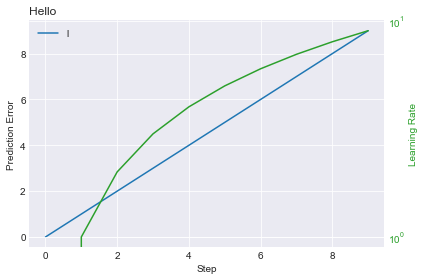

In [28]:
plot_values_with_two_y_axis(list(range(0, 10)), {"l": list(range(0, 10))}, {"k": list(range(0, 10))}, title = "Hello")

prev_check val:  Results\SDG\1e-051205\49970.json
Name:  Results\SDG\1e-051205


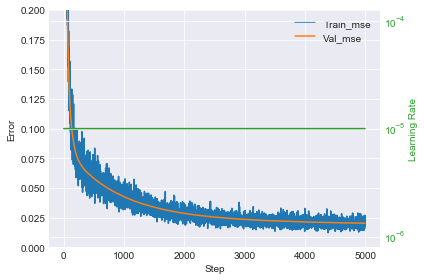

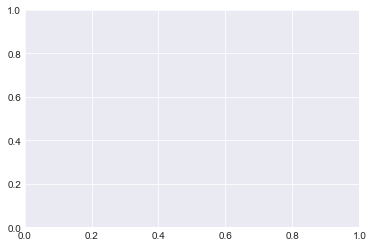

In [18]:
to_get_check_from = results_small_lr[0]

prev_check = Path(to_get_check_from["Name"], get_previous_checkpoints(to_get_check_from["Name"])[0])
print("prev_check val: ", prev_check)
prev_check = load_data_as_dict(prev_check)
print("Name: ", to_get_check_from["Name"])
plot_lr_tran_val(prev_check, ylimit = (0.0, 0.2), info_to_add = {}, save_fig = False)

In [42]:
from math import inf, isnan
def get_paths_of_results_where(results_to_get_from, value:str, value_equals):
    evals = filter(lambda x: x if x[value] == value_equals else None, results_to_get_from)
    new_evals = map(lambda x: Path(x["Name"]), evals)
    return list(new_evals)
results_small_lr = get_paths_of_results_where(results[10], "BATCH_SIZE".lower(), 20)

values_to_plot = {}
steps_to_plot = {}
# {"LR": cfg.OPTIM.LR, "batch_size": cfg.OPTIM.BATCH_SIZE, "Eval": best["Test_eval"],"Time": best["Proccess_time"], "Step": best["Step"], "Name": d}
clean_of_exploding = True
for path in results_small_lr:
    prev_check = Path(path, get_previous_checkpoints(path)[0])
    prev_check = load_data_as_dict(prev_check)
    lr = prev_check["Learning_rate"]['0']
    new_val = list(prev_check["Val_eval"].values())
    if(not clean_of_exploding or (new_val[-1] != inf and not isnan(new_val[-1]))):
        values_to_plot[f"Val_eval_{lr}"] = new_val
        steps_to_plot[f"Val_eval_{lr}"] =  list(map(int, prev_check["Train_eval"].keys()))
        print("Length: ", len(values_to_plot[f"Val_eval_{lr}"]))

Length:  21801
Length:  451
Length:  7554


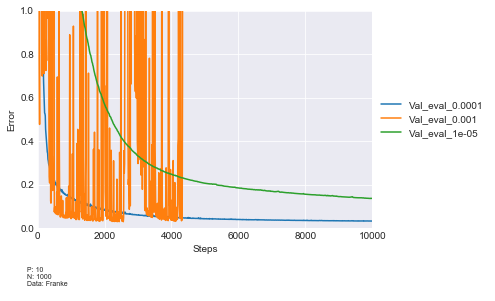

P: 10
N: 1000
Data: Franke



In [46]:

def plot_values_with_info(steps, values_to_plot, title = "", xlabel = "Steps", xlimit= None, ylimit= None,  ylabel = "Error", info_to_add = {}, xscale = "linear", save_fig = False):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots()
    for key in values_to_plot:
        ax.plot(steps[key], values_to_plot[key], label=key)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    info_str, title_info = parse_info_for_plot(info_to_add)
    
    if info_str != "":
        plt.figtext(0.1, -0.1, info_str, ha="left", fontsize=7)

    if ylimit != None:
        ax.set_ylim(ylimit[0], ylimit[1])
    if xlimit != None:
        ax.set_xlim(xlimit[0], xlimit[1])

    plt.xscale(xscale)

    if save_fig:
        save_figure(title + title_info)
    else:
        plt.show()
        print(info_str)
info_to_add = {
    "P: ": 10, 
    "N: ": 1000, 
    "Data: ": "Franke"
}
plot_values_with_info(steps_to_plot, values_to_plot,info_to_add= info_to_add,  xlimit = (0, 10000), ylimit = (0, 1))

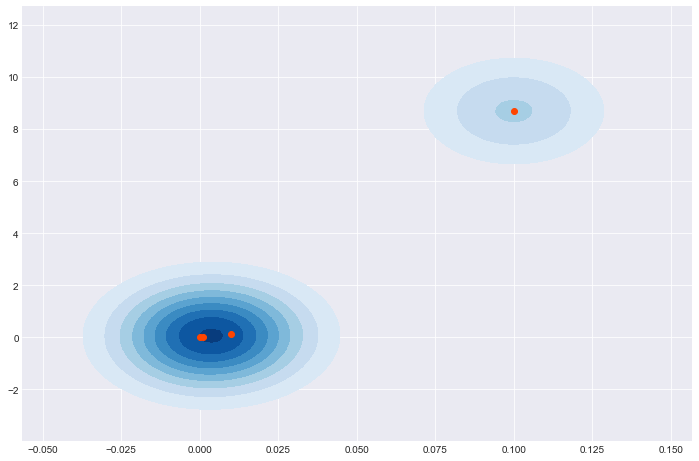

In [38]:
fig, ax = plt.subplots(1, figsize=(12,8))
n = 12
x_axis = lr[n:]
y_axis = data_dict["results"][n:]
sb.kdeplot(x_axis, y_axis, cmap='Blues',
           shade=True, shade_lowest=False)
plt.scatter(x_axis, y_axis, color='orangered')
plt.show()

# d) Classification

In [2]:
test_path = Path("Results", "d)MNISTClass_LR_Batch_size")

def get_all_results(path:Path):
    batch_sizes = [32, 60]
    all_dir = [x for x in path.iterdir() if x.is_dir()]
    results = {}
    for pol in batch_sizes:
        results[pol] = []

    for i in range(len(all_dir)):
        d = all_dir[i]
        cfg = Config(config_file = Path(d).joinpath("classification_mnist_model.yaml"))
        best = load_best_checkpoint(d)

        results[cfg.OPTIM.BATCH_SIZE].append({"LR": cfg.OPTIM.LR, "LR_DECAY": cfg.OPTIM.LR_DECAY, "Eval": best["Test_eval"],"Time": best["Proccess_time"], "Step": best["Step"], "Name": d})

    return results    

results = get_all_results(test_path)

Best val:  {'LR': 0.01, 'LR_DECAY': 0.0, 'Eval': 0.8455, 'Time': [5.0, 58.5859534740448], 'Step': 9980, 'Name': WindowsPath('Results/d)MNISTClass_LR_Batch_size/0000132')}
{'Results: ': 'test score=0.84550, time: 5 min 59', 'File name: ': 'Results_d)MNISTClass_LR_Batch_size_0000132'}
Best val:  {'LR': 0.01, 'LR_DECAY': 0.0, 'Eval': 0.7085, 'Time': [4.0, 3.9711503982543945], 'Step': 5170, 'Name': WindowsPath('Results/d)MNISTClass_LR_Batch_size/0000160')}
{'Results: ': 'test score=0.70850, time: 4 min 4', 'File name: ': 'Results_d)MNISTClass_LR_Batch_size_0000160'}


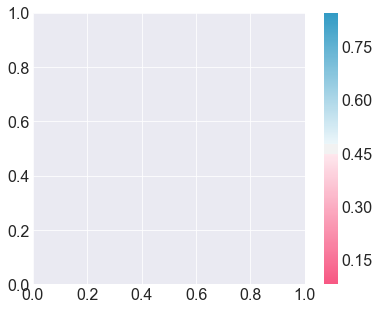

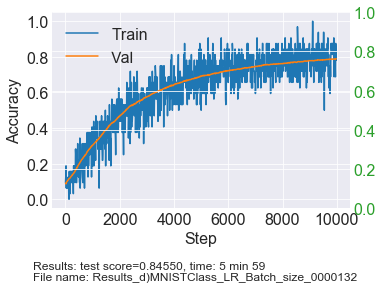

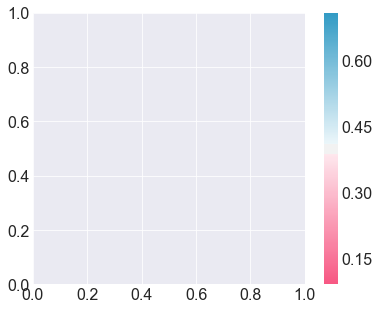

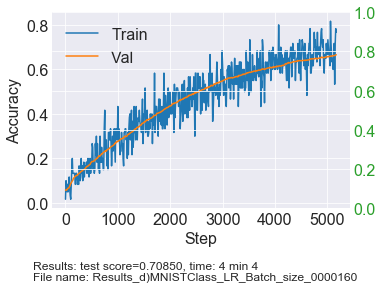

In [5]:
def analyse_results(results, values_to_analyse = ("LR_DECAY", "LR"), round_up_to: float = 1, save_fig = False):
    min_val = get_max_value(results, "Eval") # MAX WHEN ACC AND MIN WHEN MSE
    print("Best val: ", min_val)
    best_checkpoint = load_best_checkpoint(min_val["Name"])
   
    cfg = Config(config_file = Path(min_val["Name"], "classification_mnist_model.yaml"))
    p = str(cfg.OPTIM.BATCH_SIZE)

    time_for_best_run = f'{min_val["Time"][0]:.0f} min {min_val["Time"][1]:.0f}'
    best_test_eval = f'{min_val["Eval"]:.5f}'
    
    # HEAT_MAP
    info_to_add = {}
    s_results = unpack(results, values_to_unpack_on = values_to_analyse, replace_val_bigger = inf)
    position_index = s_results.index.get_loc(min_val[values_to_analyse[0]])
    position_column = s_results.columns.get_loc(min_val[values_to_analyse[1]])

    show_heatmap(s_results, info_to_add = info_to_add, patch_placement= (position_column, position_index), title = f"MNIST Classification batch size = {p}", xlabel = values_to_analyse[1], ylabel = values_to_analyse[0], show_bar = True, save_fig = save_fig)

    new_info = f'test score={best_test_eval}, time: {time_for_best_run}'
    # PLOTS
    info_to_add = {
        "Results: ": new_info,
        "File name: ": str(min_val["Name"]).replace("\\", "_"),
    }
    print(info_to_add)
    plot_lr_tran_val(best_checkpoint, y1_label = "Accuracy", title = f'Best Run batch size = {p}', info_to_add = info_to_add, save_fig = save_fig)

# def show_heatmap(data, title, xlabel, ylabel, info_to_add = {}, patch_placement = None, show_bar = True, save_fig = False):
#     cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)
#     fig, ax = plt.subplots(figsize=(7, 5))

#     sb.heatmap(data, annot=True, linewidth=0.3, cbar = show_bar, cmap=cmap, square=True, annot_kws={'size':14})  #  annot=True, fmt=".2f", 
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

#     if patch_placement != None:
#         ax.add_patch(Rectangle(patch_placement,1,1, fill=False, edgecolor='green', lw=3))

#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values
#     plt.title(title, loc='left', fontsize=18, fontweight=0)
    
#     info_str, title_info = parse_info_for_plot(info_to_add)


#     if info_str != "":
#         plt.figtext(0.1, -0.1, info_str, ha="left", fontsize=12)

#     if save_fig:
#         save_figure(title + title_info)
#         plt.cla()
#     else: 
#         plt.show()


plt.rcParams['font.size'] = 16
for batch in results:
    analyse_results(results[batch], values_to_analyse = ("LR_DECAY", "LR"), save_fig = True)